# Input sequence that maximizes feature activation
... for varying sequence length

I search for the token sequence that maximizes the activation of a given feature

## Setup

In [1]:
import torch as t
from nnsight import LanguageModel

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import sys
sys.path.append('..')
from dictionary_learning import AutoEncoder
from dictionary_circuits.attribution import patching_effect

In [9]:
DEVICE = "cuda:0"
DEBUGGING = False
D_MODEL = 512
D_SAE = 32768
DICT_ID = 10

if DEBUGGING:
    tracer_kwargs = {'validate' : True, 'scan' : True}
else:
    tracer_kwargs = {'validate' : False, 'scan' : False}

pd.set_option('display.max_rows', 100)  # Show only 10 rows

In [3]:
# Load model
model = LanguageModel(
    "EleutherAI/pythia-70m-deduped",
    device_map = DEVICE,
    dispatch = True,
)

# Load submodules and dictionaries
embed = model.gpt_neox.embed_in
attns = [layer.attention for layer in model.gpt_neox.layers]
mlps = [layer.mlp for layer in model.gpt_neox.layers]
resids = [layer for layer in model.gpt_neox.layers]
submodules = attns + mlps + resids + [embed]

dictionaries = {}
submodule_names = {}
ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/embed/{DICT_ID}_{D_SAE}/ae.pt'))
dictionaries[embed] = ae
submodule_names[embed] = 'embed'
for i in range(len(model.gpt_neox.layers)):
    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[attns[i]] = ae
    submodule_names[attns[i]] = f'attn{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[mlps[i]] = ae
    submodule_names[mlps[i]] = f'mlp{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[resids[i]] = ae
    submodule_names[resids[i]] = f'resid{i}'

## Simplest case: 1 token, embed feature

In [4]:
model.tokenizer.vocab

{'ey': 2653,
 'anie': 24132,
 'pragma': 26579,
 'sat': 22354,
 'ĠPlayers': 32392,
 'Ġmeasurements': 6341,
 'ĊĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ': 47464,
 'ĠHopefully': 33581,
 'reaction': 48235,
 'ĠDictionary': 26372,
 'ĠCancer': 13877,
 'Ġopts': 32659,
 'Ġ568': 46148,
 'Ġanonymity': 39185,
 'ardi': 24535,
 'Ġscall': 45829,
 'ĠBiosystems': 40073,
 'etter': 46467,
 '^*$,': 49538,
 'ĠRC': 20461,
 'ancement': 49808,
 'Hope': 24004,
 'inte': 8297,
 'ĠAv': 8784,
 'Ġ===': 11013,
 'Ġoptimization': 13757,
 'dump': 23593,
 'KN': 25227,
 'Ġvanilla': 26724,
 'Ġ#"': 34449,
 'Ġaerobic': 34796,
 'Represent': 35012,
 'ĠEnc': 35506,
 'Ġphysician': 12878,
 '760': 42047,
 'Ġplasticity': 30535,
 'ĠDG': 39268,
 '$;': 16446,
 'Ġfestival': 16365,
 'Ġretal': 24998,
 'Ð³Ð¾': 41623,
 'Ġrecommend': 5583,
 'Ġpermitting': 27382,
 'bbing': 30690,
 '?!': 22418,
 'ĠWal': 8178,
 'Ġroof': 10699,
 'ortunately': 6761,
 'iversity': 2095,
 'models': 19286,
 'ĠTFT': 44202,
 'Ġscandal': 20565,
 'aration': 10

In [5]:
# Create a tokenized batch where every token in the vocab is present
print(f'model vocab size: {model.config.vocab_size}')
vocab_batch = t.arange(model.config.vocab_size).unsqueeze(1).to(DEVICE)

model vocab size: 50304


In [6]:
with t.no_grad(), model.trace(vocab_batch, **tracer_kwargs):
    x = embed.output
    f = dictionaries[embed].encode(x)
    f.save()

f = f.squeeze(1).transpose(0, 1)
f.shape

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([32768, 50304])

In [7]:
# for each feature, get the top ten tokens that activate it the most
k = 100
top_values, top_indices = t.topk(f, k, dim=1)

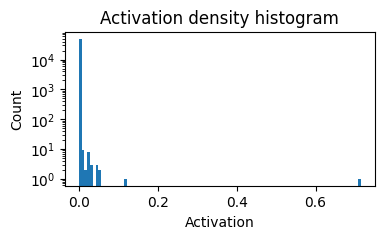

Feature 100 is most activated by tokens:


,token,activation
1,el,0.713963
2,ese,0.115142
3,questo,0.053109
4,pued,0.052569
5,nel,0.049145
6,cet,0.046613
7,ell,0.046247
8,dell,0.034488
9,más,0.033799
10,đ,0.029886


In [12]:
# Inspect some examples
feature_idx = 100 # 100 is spanish articles!

# Feature Activation density histogram
plt.figure(figsize=(4,2))
plt.hist(f[feature_idx].cpu().numpy(), bins=100)
plt.xlabel('Activation')
plt.ylabel('Count')
plt.title('Activation density histogram')
plt.yscale('log')
plt.show()

# Top 10 tokens that activate the feature the most
top_tok_feat = [model.tokenizer.decode(token_id) for token_id in top_indices[feature_idx]]
top_val_feat = top_values[feature_idx].cpu().numpy()
print(f'Feature {feature_idx} is most activated by tokens:')
df = pd.DataFrame({'token': top_tok_feat, 'activation': top_val_feat})
df = df[df.activation > 0]
df.index = df.index + 1
df